In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor

2023-04-18 21:18:11.492501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 10
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [3]:
universe = pd.read_csv(f'./data/universe/{inception_date}.csv', squeeze=True)
universe.head()

/var/folders/71/324hp9d161v598d179126g880000gn/T/ipykernel_58465/2088881067.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  universe = pd.read_csv(f'./data/universe/{inception_date}.csv', squeeze=True)


0    IMPP
1    SXTC
2    ECAT
3    MULN
4    HYMC
Name: ticker, dtype: object

In [53]:
## get ticker returns
rets = []
for aid in tqdm(universe):
    ret = pd.read_csv(f'./data/mkt/{aid}.csv', index_col=0)
    ret = ret['Close'].pct_change().dropna()
    ret = ret.rename(aid)
    rets.append(ret)
ret_all = pd.concat(rets, axis=1)
ret_all = ret_all.sort_index()
ret_all = ret_all.fillna(0)

100%|██████████| 2500/2500 [00:06<00:00, 371.94it/s]


In [54]:
ret_all

,IMPP,SXTC,ECAT,MULN,HYMC,CELZ,METX,ENSV,KAVL,BBIG,...,BRP,LIBY,VOR,BWMX,BIMI,NPCE,LIVE,DHCA,MARK,RCUS
2018-06-04,0.000000,0.000000,0.000000,-0.028369,0.000000,0.084848,0.000000,-0.081481,0.000000,-0.020000,...,0.000000,0.000000,0.000000,0.000000,0.046875,0.000000,-0.003249,0.000000,-0.015385,0.041264
2018-06-05,0.000000,0.000000,0.000000,-0.013139,0.000000,-0.134078,0.000000,-0.032258,0.000000,-0.014084,...,0.000000,0.000000,0.000000,0.000000,0.171642,0.000000,0.009780,0.000000,0.149554,-0.018576
2018-06-06,0.000000,0.000000,0.000000,-0.039941,-0.001041,-0.038710,0.000000,0.016667,0.000000,-0.010204,...,0.000000,0.000000,0.000000,0.000000,0.082803,0.000000,0.017756,0.000000,-0.048544,0.006940
2018-06-07,0.000000,0.000000,0.000000,-0.001541,0.003125,0.033557,0.000000,-0.008197,0.000000,-0.005891,...,0.000000,0.000000,0.000000,0.000000,0.082353,0.000000,-0.005551,0.000000,-0.020408,0.020050
2018-06-08,0.000000,0.000000,0.000000,0.141975,0.000000,0.103896,0.000000,-0.033058,0.000000,0.009630,...,0.000000,0.000000,0.000000,0.000000,0.084239,0.000000,0.004785,0.000000,0.039583,0.041155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.229412,0.007067,0.001362,-0.090909,-0.010283,-0.014151,-0.083333,0.056818,-0.005161,0.000000,...,0.011532,0.000000,-0.044218,0.067568,0.055556,0.110294,-0.017081,0.000000,0.018182,0.001703
2023-03-28,-0.066986,-0.017544,0.004762,-0.100000,0.096104,-0.006507,0.000000,-0.008602,-0.033722,-0.034682,...,0.000000,0.000000,-0.023132,0.019891,-0.035088,0.006622,0.008847,0.000000,-0.026786,-0.001700
2023-03-29,-0.005128,0.000000,0.016249,0.111111,-0.052133,-0.038721,0.000000,-0.045553,0.006711,-0.029940,...,-0.002850,0.000000,-0.032787,0.029255,-0.018182,0.008772,-0.013467,0.000000,-0.009174,0.024404
2023-03-30,-0.051546,-0.017857,0.012658,0.200000,0.092500,-0.028858,0.000000,0.045455,-0.045333,-0.009259,...,0.021233,0.000476,-0.013183,-0.012920,-0.037037,0.069565,0.055238,0.000000,0.000000,-0.032687


In [7]:
from scipy.stats import skew, kurtosis
skew(ret_all_flat), kurtosis(ret_all_flat, fisher=True)

(2.165479175649352, 29.116752413268642)

<Axes: ylabel='Density'>

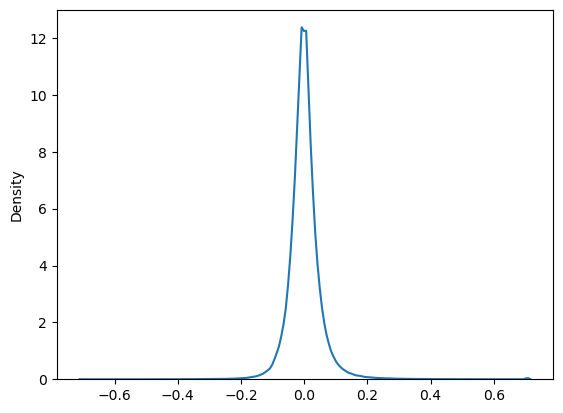

In [58]:
train = ret_all.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].values
train_flat = train.flatten()
train_flat = train_flat[train_flat != 0]
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-2*s, m+2*s)
sns.kdeplot(train_flat)

In [59]:
train.shape

(504, 2500)

In [60]:
X = []
y = []
for i in range(train.shape[0] - WIN_LEN):
    X.append(train[i:i+WIN_LEN, :])
    y.append(train[i+WIN_LEN, :])
X = np.array(X)
y = np.array(y)

In [61]:
X.shape, y.shape

((494, 10, 2500), (494, 2500))

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((370, 10, 2500), (124, 10, 2500), (370, 2500), (124, 2500))

In [67]:
lstm_cov = keras.Sequential([
    layers.LSTM(64, return_sequences=False),
    layers.Dense(UNIVERSE_SIZE),
])

In [68]:
lstm_cov.compile(
    optimizer='rmsprop',
    loss='mse',
)
# lstm_cov.build(X_train[0:BATCH_SIZE, :, :])
# lstm_cov.summary()

In [69]:
esc = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='auto',
)

history_lstm_cov = lstm_cov.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE)
    

Epoch 1/20
24/24 [==============================] - 2s 23ms/step - loss: 0.1420 - val_loss: 0.0059
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1418 - val_loss: 0.0059
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.0059
Epoch 4/20
24/24 [==============================] - 0s 11ms/step - loss: 0.1413 - val_loss: 0.0060
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1409 - val_loss: 0.0060
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1405 - val_loss: 0.0062
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1401 - val_loss: 0.0061
Epoch 8/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1397 - val_loss: 0.0062
Epoch 9/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.0062
Epoch 10/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1391 - val_loss: 0.0062
Epoch 11/

<Axes: >

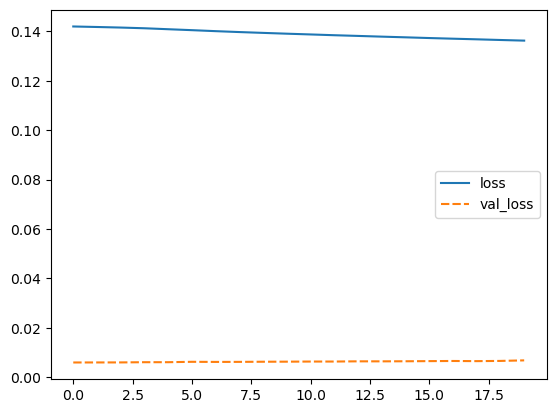

In [70]:
sns.lineplot(history_lstm_cov.history)

In [120]:
## get ticker returns
test_start_date = ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
test = ret_all.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN].values
test = test.clip(m-2*s, m+2*s)
X_test = []
y_test = []
for i in range(test.shape[0] - WIN_LEN):
    X_test.append(test[i:i+WIN_LEN, :])
    y_test.append(test[i+WIN_LEN, :])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [121]:
test_index = ret_all.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN].index[WIN_LEN:]

In [122]:
y_test.shape

(251, 2500)

In [123]:
y_pred_test = lstm_cov.predict(X_test)

8/8 [==============================] - 0s 6ms/step


In [124]:
y_pred_test.shape

(251, 2500)

In [125]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

def plot_mse(pred: pd.DataFrame, gt: pd.DataFrame, index: [pd.Timestamp]) -> plt.Axes:
    if pred.shape != gt.shape:
        logger.error('Index not match for pred and gt')
        raise ValueError('Index not match for pred and gt')
    

    mse_by_time = ((pred - gt) ** 2).sum(axis=1)
    mse_df = pd.Series(mse_by_time, index=index)
    mse_df.index = pd.to_datetime(mse_df.index)
    plot = mse_df.plot.line()
    return plot, mse_df


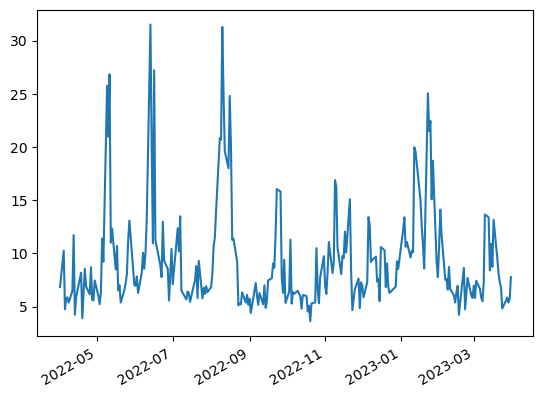

In [126]:
ax, mse_df = plot_mse(y_pred_test, y_test, test_index)